# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
128330,1703818259999,0.000473,1m,2023-12-29 02:50:59.999,0.000517,-0.000045,-0.526804
128331,1703818319999,0.000473,1m,2023-12-29 02:51:59.999,0.000517,-0.000045,-0.521064
128332,1703818379999,0.000473,1m,2023-12-29 02:52:59.999,0.000517,-0.000045,-0.553188
128333,1703818439999,0.000472,1m,2023-12-29 02:53:59.999,0.000517,-0.000045,-0.620815
128334,1703818499999,0.000472,1m,2023-12-29 02:54:59.999,0.000517,-0.000045,-0.648032
128335,1703818559999,0.000472,1m,2023-12-29 02:55:59.999,0.000517,-0.000045,-0.614207
128336,1703818619999,0.000472,1m,2023-12-29 02:56:59.999,0.000517,-0.000045,-0.634453
128337,1703818679999,0.000472,1m,2023-12-29 02:57:59.999,0.000517,-0.000045,-0.636489
128338,1703818739999,0.000472,1m,2023-12-29 02:58:59.999,0.000510,-0.000038,0.353753
128339,1703818799999,0.000472,1m,2023-12-29 02:59:59.999,0.000507,-0.000034,0.793832


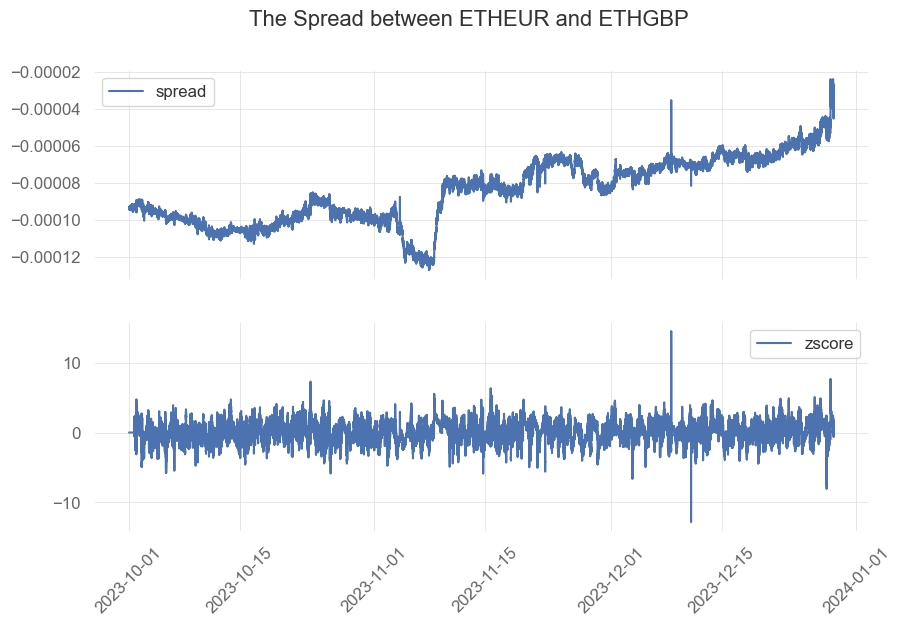

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 41040


## Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 11/41040 [00:00<06:50, 100.00it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:1.0, networth: 1.0


 10%|█         | 4112/41040 [01:19<14:48, 41.57it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.0, networth: 1.0128


 20%|██        | 8231/41040 [02:08<04:56, 110.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.0, networth: 1.018


 30%|███       | 12325/41040 [02:50<04:49, 99.13it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.0, networth: 1.0302


 40%|████      | 16437/41040 [03:33<04:01, 101.88it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.0379


 50%|█████     | 20537/41040 [04:14<03:27, 98.72it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:1.0, networth: 1.0642


 60%|██████    | 24641/41040 [04:55<02:39, 102.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.0858


 70%|███████   | 28739/41040 [05:34<01:49, 111.88it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:1.0, networth: 1.0958


 80%|████████  | 32844/41040 [06:10<01:12, 113.04it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:1.0, networth: 1.1096


 90%|█████████ | 36950/41040 [06:45<00:34, 120.18it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.1137


100%|██████████| 41040/41040 [07:19<00:00, 93.41it/s] 

Finished
networth: 1.1194257308066176


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 17/41040 [00:00<04:03, 168.80it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:1.0, networth: 1.0


 10%|█         | 4109/41040 [02:03<23:07, 26.62it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.0, networth: 1.0225


 20%|██        | 8218/41040 [02:56<05:27, 100.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.0, networth: 1.0363


 30%|███       | 12327/41040 [03:33<04:21, 109.83it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 0, reward:1.0, networth: 1.0402


 40%|████      | 16428/41040 [04:11<03:43, 110.34it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.0588


 50%|█████     | 20538/41040 [04:49<03:04, 111.10it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 0, reward:1.0, networth: 1.0948


 60%|██████    | 24643/41040 [05:27<02:31, 108.18it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.13


 70%|███████   | 28738/41040 [06:04<01:52, 109.44it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 0, reward:1.0, networth: 1.1451


 80%|████████  | 32844/41040 [06:42<01:15, 108.63it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 0, reward:1.0, networth: 1.1642


 90%|█████████ | 36957/41040 [07:20<00:36, 111.34it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.1762


100%|██████████| 41040/41040 [07:57<00:00, 85.96it/s] 


Finished
networth: 1.1825144025658778


In [15]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|          | 13/41040 [00:00<05:17, 129.03it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 0, reward:0.0, networth: 1.0


 10%|█         | 4118/41040 [00:41<06:35, 93.38it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.0, networth: 0.9965


 20%|██        | 8218/41040 [01:17<04:06, 133.00it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.0, networth: 0.9937


 30%|███       | 12331/41040 [01:48<03:34, 133.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.0, networth: 0.9928


 40%|████      | 16426/41040 [02:23<03:57, 103.48it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 0.9891


 50%|█████     | 20532/41040 [02:58<03:02, 112.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:1.0, networth: 0.9809


 60%|██████    | 24641/41040 [03:34<02:25, 112.88it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 0.9731


 70%|███████   | 28742/41040 [04:11<01:51, 110.51it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:1.0, networth: 0.9687


 80%|████████  | 32848/41040 [04:48<01:14, 110.45it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:1.0, networth: 0.9609


 90%|█████████ | 36957/41040 [05:28<00:42, 96.96it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 0, reward:0.0, networth: 0.9606


100%|██████████| 41040/41040 [06:09<00:00, 110.98it/s]

Finished
networth: 0.9601071602221323


## Also run randomly generated actions

In [16]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 14/41040 [00:00<04:57, 137.76it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 0, reward:0.0, networth: 1.0


 10%|█         | 4114/41040 [00:47<07:34, 81.24it/s] 

signal: {'position': 0, 'zone': 2, 'zscore': array([-0.1520439])}, action: 0, reward:0.0, networth: 1.0054


 20%|██        | 8229/41040 [01:23<04:39, 117.30it/s]

signal: {'position': 1, 'zone': 2, 'zscore': array([0.08627466])}, action: 2, reward:0.0, networth: 0.9988


 30%|███       | 12328/41040 [01:58<04:20, 110.06it/s]

signal: {'position': 2, 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.019, networth: 0.9977


 40%|████      | 16431/41040 [02:32<03:18, 123.87it/s]

signal: {'position': 1, 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.0009


 50%|█████     | 20536/41040 [03:06<02:53, 118.34it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:-0.009, networth: 1.0015


 60%|██████    | 24644/41040 [03:40<02:09, 126.26it/s]

signal: {'position': 1, 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.0001


 70%|███████   | 28745/41040 [04:12<01:40, 121.97it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.68014561])}, action: 2, reward:0.0, networth: 1.012


 80%|████████  | 32856/41040 [04:46<01:05, 124.13it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:-0.005, networth: 1.003


 90%|█████████ | 36951/41040 [05:20<00:31, 128.29it/s]

signal: {'position': 0, 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.0081


100%|██████████| 41040/41040 [05:52<00:00, 116.35it/s]

Finished
networth: 1.0100092930356066


### Analyze with Quanstats

In [17]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 03:00:59.999000', '1.1825144025658778']
The ending capital of networth_dqn.csv is ['2023-11-30 03:00:59.999000', '0.9601071602221323']
The ending capital of networth_ppo.csv is ['2023-11-30 03:00:59.999000', '1.1194257308066176']
The best model is networth_a2c.csv


In [18]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 791%
Total orders count: 41039
Total long action: 5089
Total short action: 17401
Won orders count: 1525
Lost orders count: 73
Win/Loss order ratio: 20.89041095890411
Max win: 0.0025520601652273545
Max Loss: -0.0033752541744684894
Avg order pnl: 4.447340397326392e-06
Avg order pnl won: 0.00012839715703544
Avg order pnl lost: -0.0001820720810023042


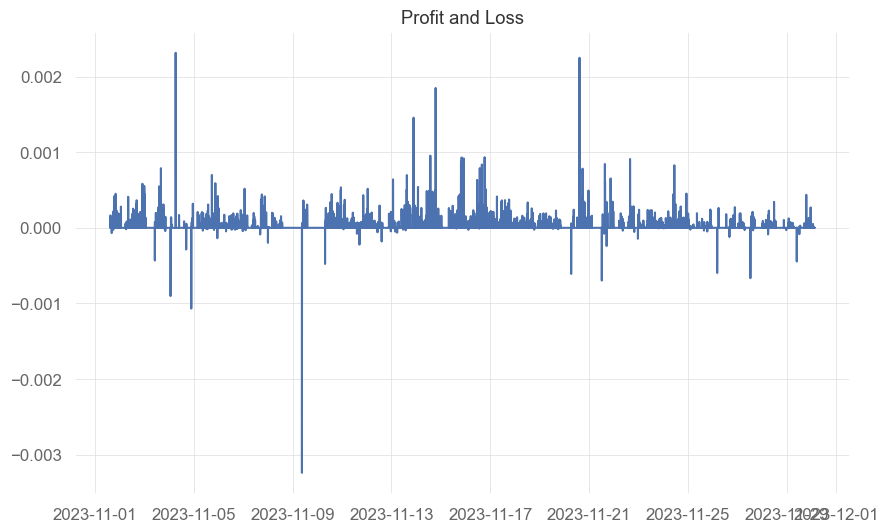

In [19]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-11-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             4.0%

Cumulative Return          18.25%
CAGR﹪                     352.12%

Sharpe                     1.54
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.53
Sortino                    3.38
Smart Sortino              3.35
Sortino/√2                 2.39
Smart Sortino/√2           2.37
Omega                      14.59

Max Drawdown               -0.32%
Longest DD Days            2
Volatility (ann.)          0.07%
Calmar                     1086.66
Skew                       4.37
Kurtosis                   1511.72

Expected Daily %           0.0%
Expected Monthly %         18.25%
Expected Yearly %          18.25%
Kelly Criterion            88.89%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-09,2023-11-09,2023-11-10,2,-0.324043,-0.311793
2,2023-11-04,2023-11-04,2023-11-05,1,-0.128756,-0.120263
3,2023-11-04,2023-11-04,2023-11-04,1,-0.090257,-0.089153
4,2023-11-21,2023-11-21,2023-11-21,1,-0.069730,-0.059669
5,2023-11-27,2023-11-27,2023-11-27,1,-0.068521,-0.053161


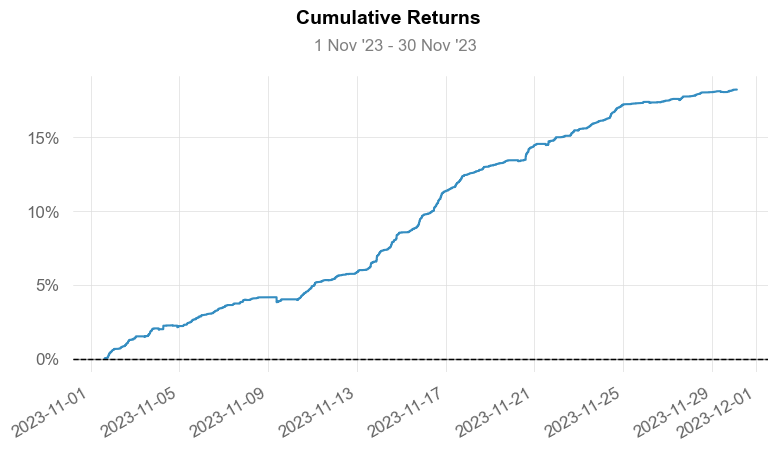

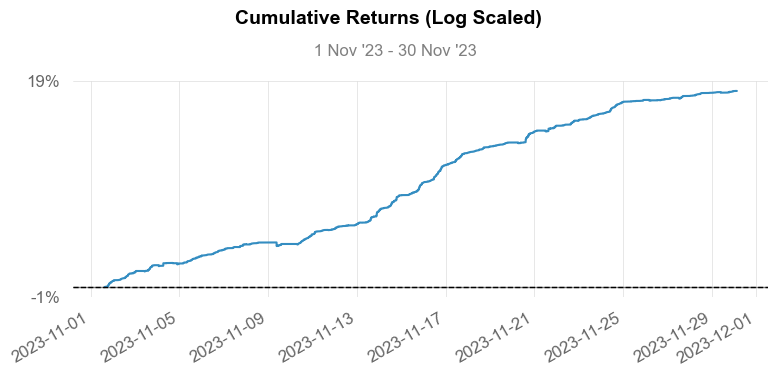

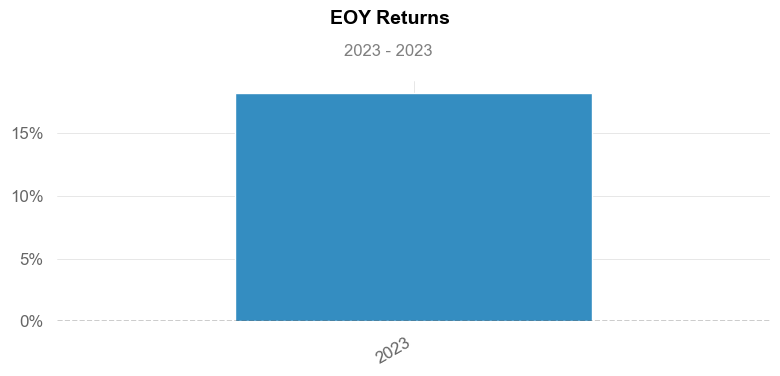

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


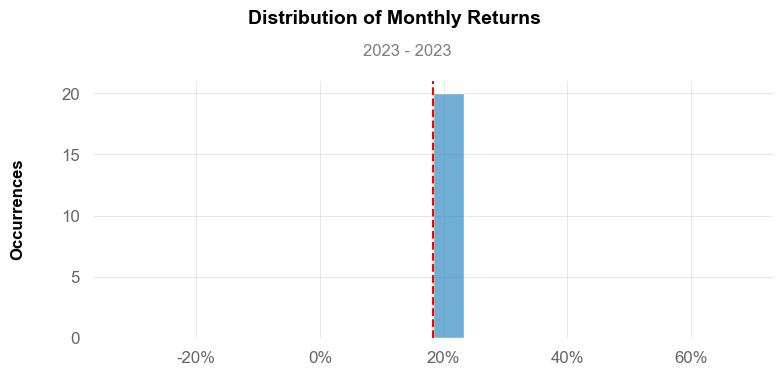

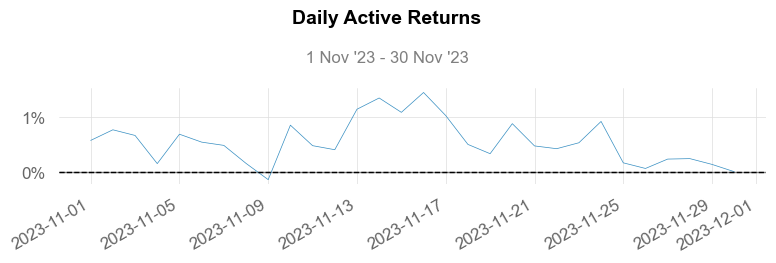

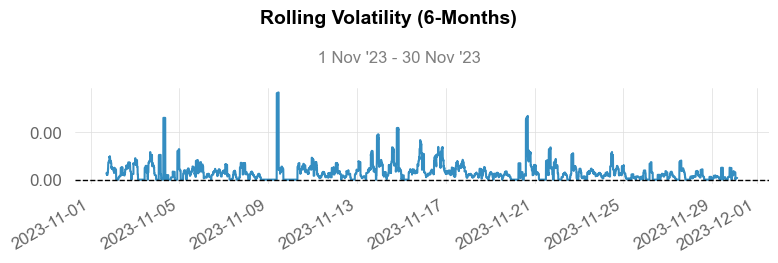

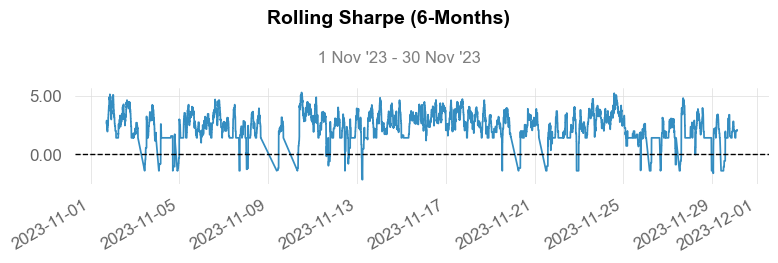

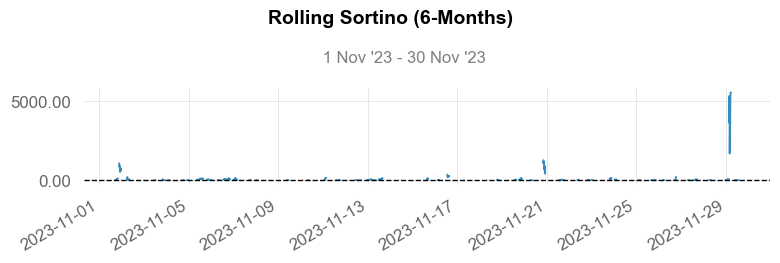

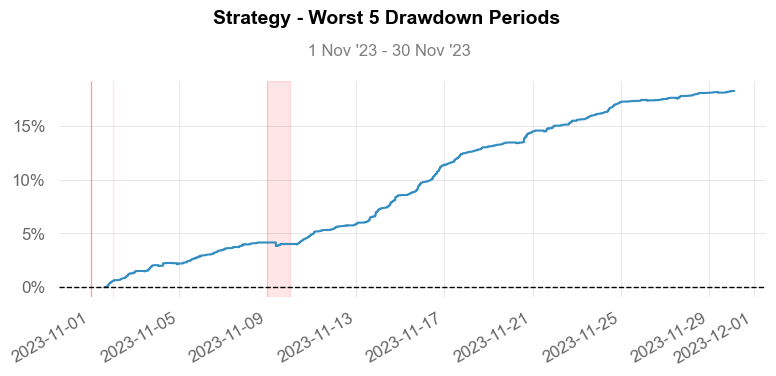

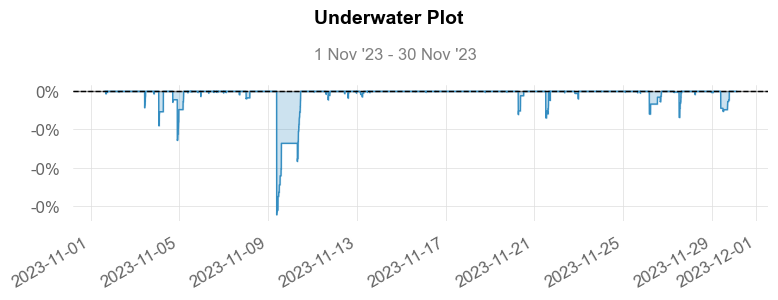

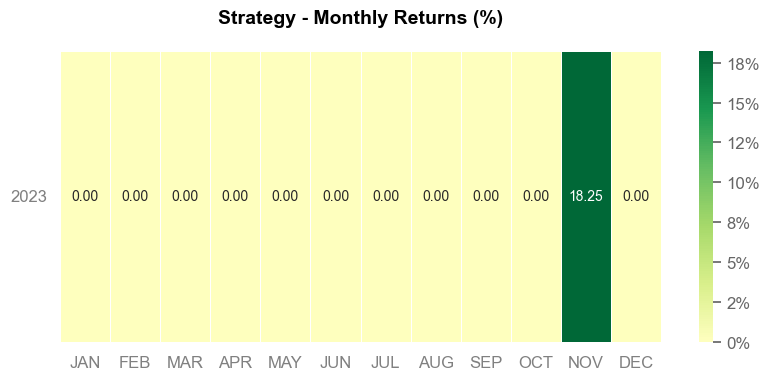

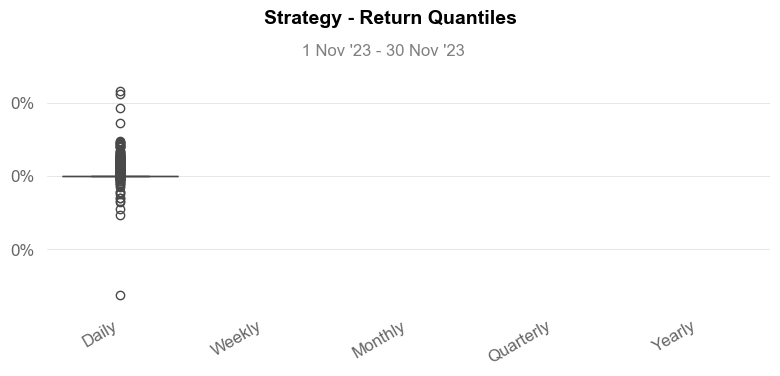

In [20]:
qs.reports.full(best_return['returns'])